In [85]:
# module: read data

%load_ext autoreload
%autoreload 2

from graphical_table import read_dataset, make_graph

data_path = "/Users/luofanghao/work/USC_lab/isi-II/work/DSBox_project/dsbox-data/o_38/original/data/trainData.csv"
data = read_dataset(data_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
# module: make graph from data
graph = make_graph(data)

In [134]:
# module: from graph -> formated nodes adj list, for LINE
from graphical_table import get_list
ad_list = get_list(graph)
with open("./o_38_line_input.txt", "w") as f:
    for line in ad_list:
        f.write(line)
        f.write("\n")

f.close()

In [165]:
# module: LINE vectors -> row nodes vectors
with open("./o_38_vector.txt") as f:
    content = f.readlines()

content = [x.strip() for x in content] 
content = [x.strip() for x in content] 

vector_dataset = {} #key is the original row id, value is the vector obtained from graph
for each in content[1:]:
    vector = each.split(" ")
    key = vector[0]
    vector = vector[1:]
    if (key[0:3]=="row"): # get the row vectors
        vector_dataset[int(key[4:])] = vector

with open("./o_38_row_vector_200.txt", "w") as f:
    for i in range(len(vector_dataset)):
        f.write(' '.join(vector_dataset[i]))
        f.write("\n")

f.close()

In [86]:
import re
import random
def random_sample_LINE(dataset, line_vec_path, store_data_path, store_label_path, with_column):
    # module: LINE vectors -> cell nodes vectors, labeled by column_id (50 samples)
    # update: include with the column nodes vectors, labeled by (counter+100) (will be: 100, 101, 102 ... )

    with open(line_vec_path) as f:
        content = f.readlines()
    content = [x.strip() for x in content] 
    content = [x.strip() for x in content] 

    column_cell_vectors = {}# key: column number, value: list of column
    column_node_vectors = {}# key: column name, value: vector
    counter = 0
    for each in content[1:]:
        vector = each.split(" ")
        key = vector[0]
        vector = vector[1:]
        # if needs, get column nodes
        if (with_column and key in dataset.keys()):  
            column_node_vectors[counter+100] = vector
            counter+=1

        m = re.search(r"^[0-9]+_", key)
        if (m != None): # get the cell nodes column
            column_num = m.group()[:-1]
            if (column_num in column_cell_vectors.keys()):
                column_cell_vectors[column_num].append(vector)
            else:
                column_cell_vectors[column_num] = []
                column_cell_vectors[column_num].append(vector)


    with open(store_data_path, "w") as data, open(store_label_path, "w") as label:
        for i in column_cell_vectors.keys():
#             print i
            all_vectors = column_cell_vectors[i]
            # random sample from all nodes, size: 50
            index = random.sample(range(len(all_vectors)),  50)
            for ind in index:
                vector = all_vectors[ind]
                data.write(' '.join(vector))
                data.write("\n")
                label.write(i)
                label.write("\n")
        for i in column_node_vectors.keys():
#             print i
            data.write(' '.join(column_node_vectors[i]))
            data.write("\n")
            label.write(str(i))
            label.write("\n")

    data.close()
    label.close()
    
def random_row_sample_LINE(dataset, line_vec_path, store_data_path, store_label_path, with_column):
    """
    different with random_sample_LINE: sample with row; then each get all cells from the rows
    """
    
    with open(line_vec_path) as f:
        content = f.readlines()

    content = [x.strip() for x in content] 
    content = [x.strip() for x in content] 

    #random sample from all rows, size: 50
    index = random.sample(range(len(dataset)),  50)

    column_cell_vectors = {}# key: column number, value: list of column
    column_node_vectors = {}# key: column name, value: vector
    counter = 0
    for each in content[1:]:
        vector = each.split(" ")
        key = vector[0]
        vector = vector[1:]
        # if needs, get column nodes
        if (with_column and key in dataset.keys()):  
            column_node_vectors[counter+100] = vector
            counter+=1

        m = re.search(r"^[0-9]+_", key)
        if (m != None): # get the cell nodes column
            # row index
            row_id = re.search(r"_[0-9]+", key).group()[1:]
            if (int(row_id) not in index): continue

            column_num = m.group()[:-1]
            if (column_num in column_cell_vectors.keys()):
                column_cell_vectors[column_num].append(vector)
            else:
                column_cell_vectors[column_num] = []
                column_cell_vectors[column_num].append(vector)


    with open(store_data_path, "w") as data, open(store_label_path, "w") as label:
        for i in column_cell_vectors.keys():
#             print i
            all_vectors = column_cell_vectors[i]
            for vector in all_vectors:
                data.write(' '.join(vector))
                data.write("\n")
                label.write(i)
                label.write("\n")
        for i in column_node_vectors.keys():
#             print i
            data.write(' '.join(column_node_vectors[i]))
            data.write("\n")
            label.write(str(i))
            label.write("\n")

    data.close()
    label.close()

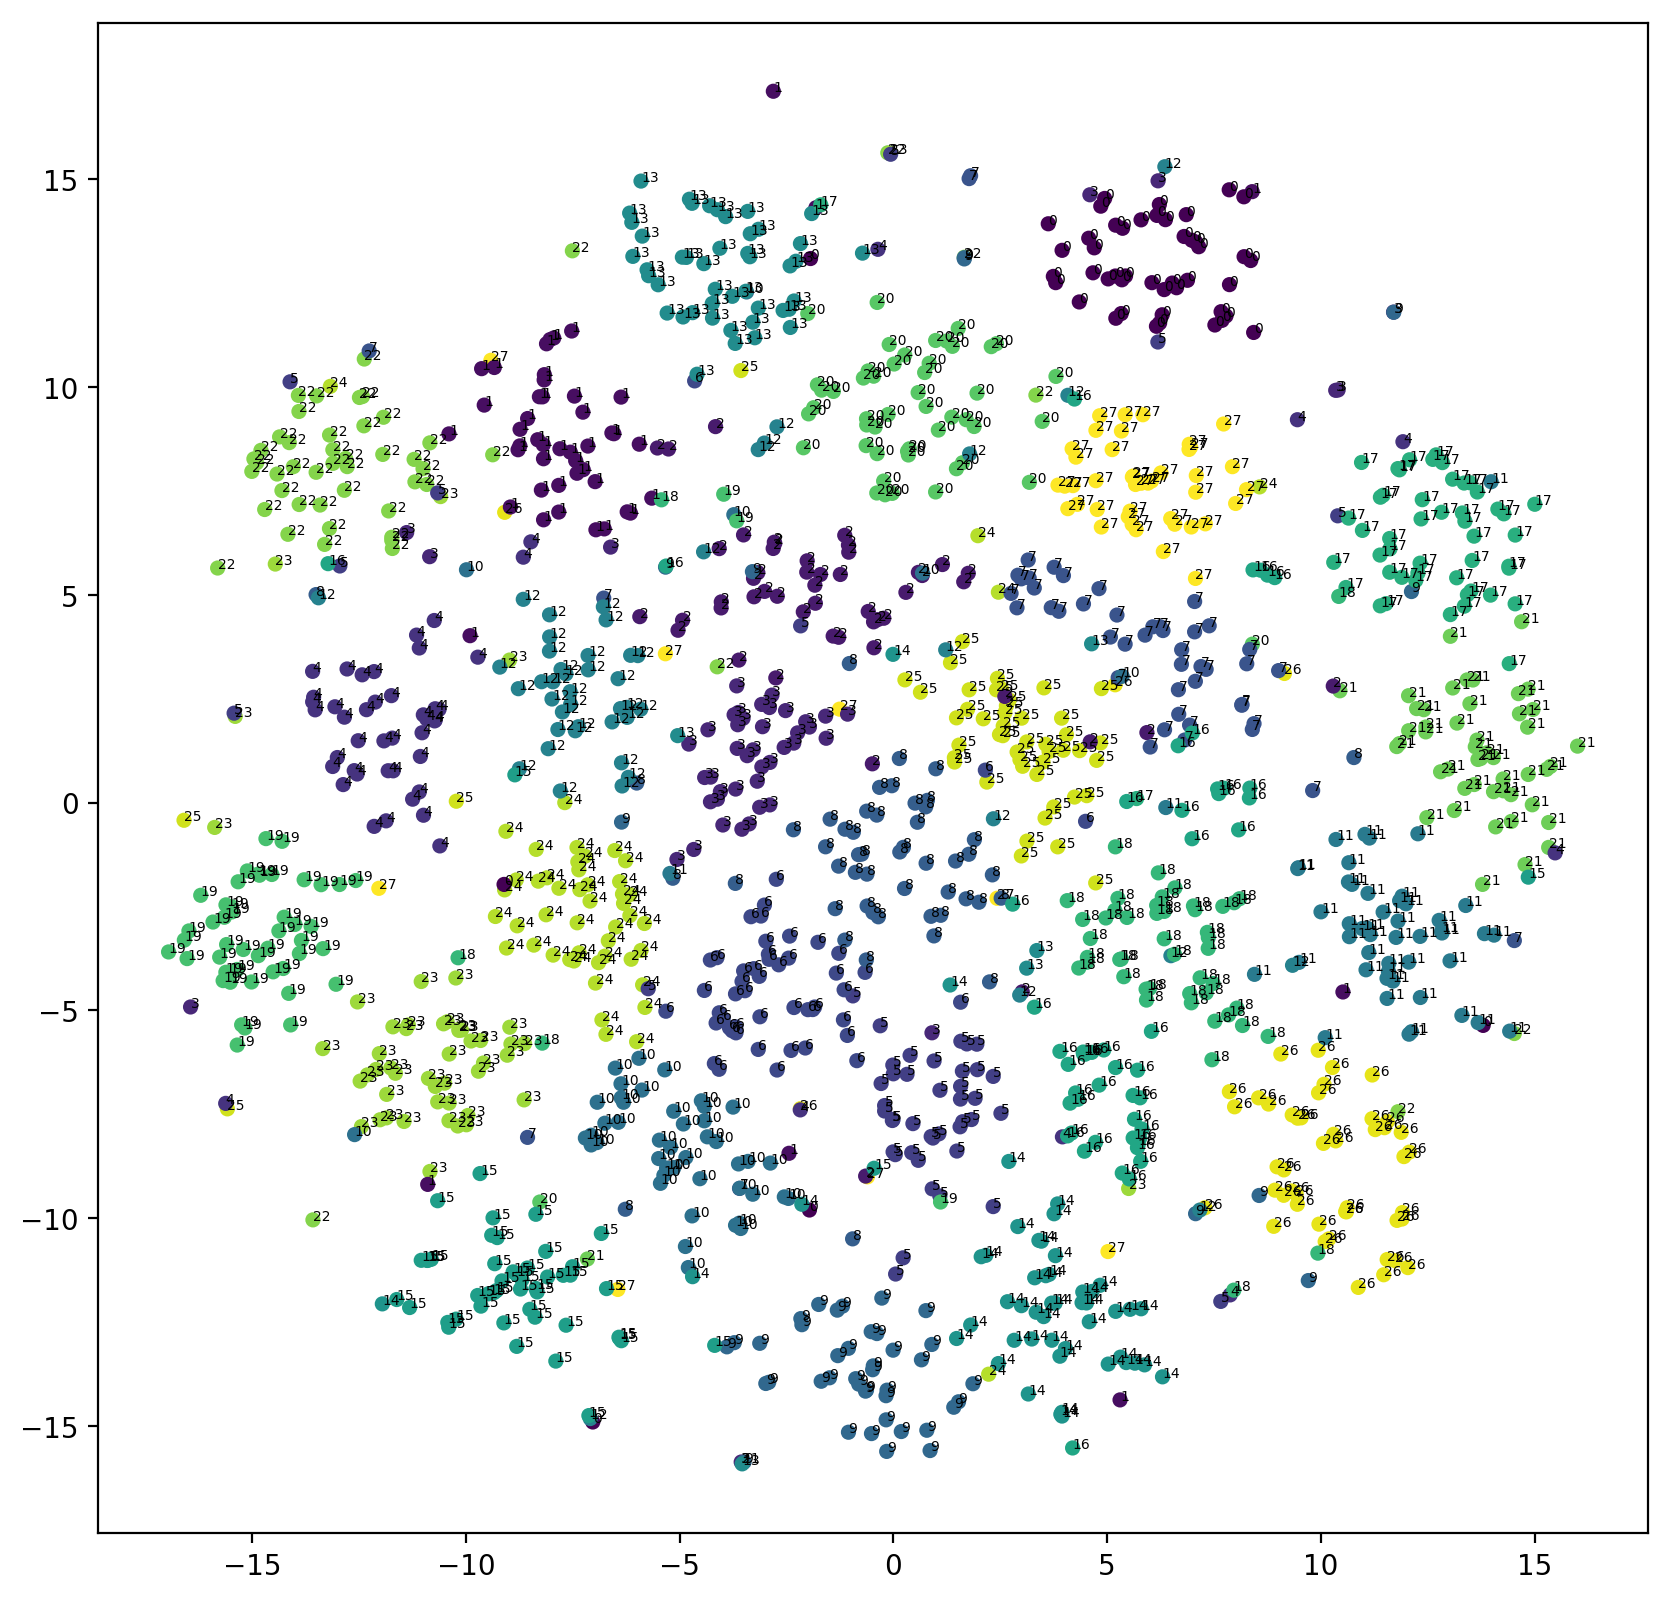

In [87]:
# tsne visulize samples result
from sklearn.manifold import TSNE
import numpy as np
random_sample_LINE(data, "./o_38_vector_100.txt", 
                   "o_38_column_cells_data_100_sample50_r.txt", 
                   "o_38_column_cell_label_sample50_r.txt", False)

samples = np.loadtxt("o_38_column_cells_data_100_sample50_r.txt")
labels = np.loadtxt("o_38_column_cell_label_sample50_r.txt")
samples_embeded = TSNE(n_components=2).fit_transform(samples)

import matplotlib.pyplot as Plot
Plot.figure(figsize=(10,10), dpi=200)
Plot.scatter(samples_embeded[:,0][:1400], samples_embeded[:,1][:1400], 20, labels[:1400])
for i in range(len(samples_embeded[:,0])):
        Plot.text(samples_embeded[:,0][i], samples_embeded[:,1][i] , int(labels[i]), fontsize=5)
# Plot.scatter(samples_embeded[:,0][1401:], samples_embeded[:,1][1401:], 50, 'b', 'x')

Plot.show()

In [88]:
from scipy.spatial.distance import cosine
def avgLinkage(cluster1, cluster2):
    result = 0
    for i in cluster1:
        for j in cluster2:
            result += cosine(i,j)
    result = result/len(cluster1)/len(cluster2) 
    return result
    

columns_id = np.unique(labels)
matrix = np.zeros((len(columns_id), len(columns_id)))
# 0, 1, 2 ... n
for i in columns_id:
    for j in columns_id:
        if (i == j): matrix[i][j] = 1
        else:
            # compute Average Linkage btw two clusters
            cluster_i = samples[labels == i]
            cluster_j = samples[labels == j]
            matrix[i][j] = avgLinkage(cluster_i, cluster_j)


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [84]:
np.savetxt("matrix.csv",matrix,delimiter=',')